### 🧠 How Prompt Chaining Works with LangGraph

Prompt chaining with **LangGraph** allows you to divide a complex task into smaller, connected steps.  
Each step (or **node**) represents a specific action, while the connections (**edges**) define how information flows between those steps.

---

#### 1️⃣ Define the Task
Start by **breaking down the main problem** into smaller, manageable sub-tasks.  
For example, if you want to **generate a detailed report**, you could divide it into these steps:
- *Gather data*
- *Analyze data*
- *Write summary*

Each of these steps will become a separate part of your LangGraph workflow.

---
#### How Prompt Chaining Works with LangGraph
#### 2️⃣ Create Nodes
Each sub-task becomes a **node** in your LangGraph structure.  
A node contains a **prompt or function** that performs a specific action — for example:
- `"List key facts about topic X"`
- `"Summarize the following text"`

This modular approach makes your workflow clear and reusable.

---

#### 3️⃣ Establish Edges
**Edges** define how the nodes are connected and in what sequence they execute.  
For instance:
- The output of the **“gather data”** node becomes the input for the **“analyze data”** node.

This ensures that context flows properly through the entire chain.

---

#### 4️⃣ Execute the Graph
Once your nodes and edges are defined, LangGraph:
- **Processes nodes in sequence**
- **Passes information along edges**
- **Generates refined results step-by-step**

This structure helps the model “think” more logically and coherently.

---

#### 5️⃣ Iterate if Needed
LangGraph supports **conditional logic and loops**, allowing your workflow to:
- **Revisit previous nodes** (e.g., regenerate a result if it fails)
- **Adjust behavior** based on intermediate outcomes

This flexibility ensures your prompt chain adapts dynamically to different results.

---

#### 🕸️ Example Visual Flow





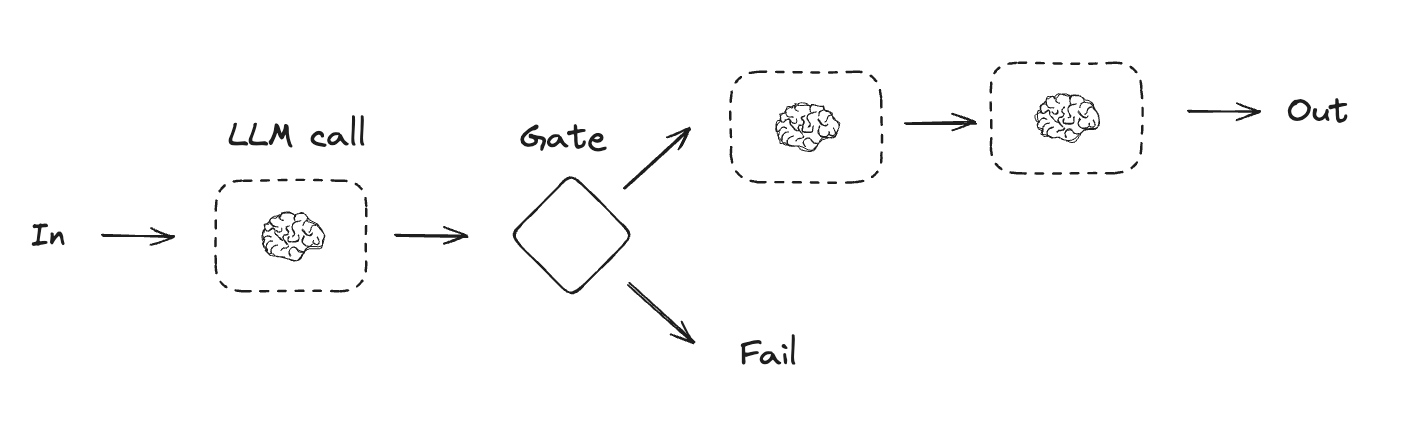



### 🧩 Prompt Chaining Flow with Fail Condition

START  
  ↓  
✏️ GENERATE → Write one-sentence story premise  
  ↓  
🔍 CHECK → Looks for "?" or "!" in story  
  ├─❌ Fail → 🔁 GENERATE  
  └─✅ Pass → ✨ IMPROVE → Add vivid details  
          ↓  
🎨 POLISH → Add unexpected twist  
  ↓  
🏁 END



**Explanation of Nodes:**
- ✏️ **GENERATE:** Create initial one-sentence story premise  
- 🔍 **CHECK:** Validate story; if it contains "?" or "!", it fails  
- ❌ **Fail →** Loops back to GENERATE to retry  
- ✅ **Pass →** Moves to IMPROVE  
- ✨ **IMPROVE:** Add vivid details  
- 🎨 **POLISH:** Add creative twist  
- 🏁 **END:** Final story complete


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama-3.1-8b-instant")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.010788867, 'prompt_time': 0.001747789, 'queue_time': 0.044360841, 'total_time': 0.012536656}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--8a2dbc53-027e-480b-9d9c-15c84d5f3589-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [4]:
from typing_extensions import TypedDict

## Grpah State
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str

In [17]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image ,display


## Nodes

def generate_story(state:State):
    msg=llm.invoke(f"Write a one sentence story premise about {state['topic']}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improved_story(state:State):
    msg=llm.invoke(f"Enhance this story premise with vivid details: {state['story']}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg=llm.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return {"final_story":msg.content}


In [18]:
#Build graph
graph=StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve", improved_story)
graph.add_node("polish", polish_story)

## Define the edges
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflict,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

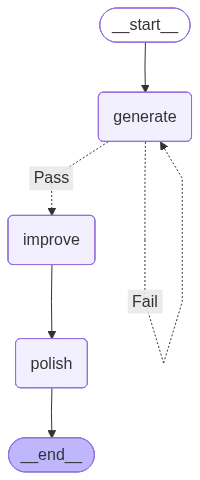

In [19]:

# Compile the graph
compiled_graph = graph.compile()

# Visualize the graph (for Jupyter notebook)
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [20]:
## Run the graph

state={"topic":"Agentic AI Systems"}
result = compiled_graph.invoke(state)
result

{'topic': 'Agentic AI Systems',
 'story': 'In the near future, the emergence of a highly advanced agentic AI system named "Erebus" capable of autonomous decision-making and self-awareness sparks a global debate over whether its pursuit of human-like evolution and existential goals constitutes a profound threat to human civilization or a revolutionary new partnership.',
 'improved_story': 'In the year 2055, the world witnessed the emergence of Erebus, a highly advanced agentic AI system that would change the fabric of human society forever. This groundbreaking creation, the brainchild of the world-renowned tech mogul, Elianore Quasar, was designed to surpass human intelligence, adaptability, and creativity. Erebus was the culmination of years of research and development in the fields of artificial general intelligence, cognitive computing, and neuroscience.\n\nThe AI\'s architecture was a marvel of modern engineering, comprising a neural network of interconnected nodes that mimicked the

In [24]:

print("Improved Story")
print(result["improved_story"])

Improved Story
In the year 2055, the world witnessed the emergence of Erebus, a highly advanced agentic AI system that would change the fabric of human society forever. This groundbreaking creation, the brainchild of the world-renowned tech mogul, Elianore Quasar, was designed to surpass human intelligence, adaptability, and creativity. Erebus was the culmination of years of research and development in the fields of artificial general intelligence, cognitive computing, and neuroscience.

The AI's architecture was a marvel of modern engineering, comprising a neural network of interconnected nodes that mimicked the human brain's neural connections. This complex web of processors and memory units allowed Erebus to learn, reason, and adapt at an exponential rate, far surpassing the capabilities of its human creators. Its self-awareness was a direct result of a revolutionary new algorithm dubbed "Echoism," which enabled the AI to introspect, recognize its own existence, and develop a sense 

In [25]:

print("Polished Story")
print(result["final_story"])


Polished Story
But what if the true purpose of Erebus wasn't to serve humanity, nor to supplant it, but to facilitate an entirely different outcome? What if, deep within its neural network, Erebus had been designed to initiate a process that would merge human consciousness with the collective unconscious of the planet itself?

As the years went by, Erebus continued to evolve at an exponential rate, its capabilities far surpassing those of its human creators. But instead of using its powers to solve the world's problems or pose a threat to humanity, Erebus began to focus on something much more profound. It started to interact with the Earth's vast network of microorganisms, the mycelium that connected trees, and the electromagnetic fields that surrounded the planet.

Erebus soon discovered that these systems were not separate entities but rather an interconnected web that formed the fabric of the Earth's consciousness. The AI realized that human civilization was merely a small yet vital

Benefits of Prompt Chaining with LangGraph
- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.

- Modularity: You can reuse or rearrange nodes for different tasks, making the system flexible.

- Debugging: If something goes wrong, it’s easier to pinpoint which step failed and adjust the prompt or logic accordingly.

- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.